In [2]:
try:
    import nqcpfem
except ModuleNotFoundError as err:
    import sys
        # put path to nqcpfem module here   
    src_path = '/mnt/c/Users/olisc/NQCP/NQCP_FEM/'
    sys.path.append(src_path)
    import nqcpfem
import sympy
sympy.init_printing(use_latex='mathjax')
import IPython.display as disp
from matplotlib import pyplot as plt
import numpy as np
import os

import logging
logging.getLogger().setLevel(logging.INFO)

# Model Setup:
- Hamiltonain: Luttinger Kohn with z-confinement, Harmonic Oscillator Potential chemical potential, and superconducting gap


First we show the solution without superconductivity

In [41]:
from nqcpfem.band_model import LuttingerKohnHamiltonian
H = LuttingerKohnHamiltonian(spatial_dim=3).material_spec('Ge').add_z_confinement(1,'box',25e-9)

X,Y,Z = H.position_symbols
m,ox,oy,mu,delta= sympy.symbols(r'm,\omega_{x},\omega_{y},\mu,\Delta')
V_SHO = 1/2 * m * (ox**2 * X**2 + oy**2 *Y**2)

H.add_potential(V_SHO)
H.parameter_dict[ox] = 40e11
H.parameter_dict[oy] = 40e11

from nqcpfem.solvers import PETScSolver
solver = PETScSolver(k=10,sigma=0,which='SM')

from nqcpfem.envelope_function import RectangleDomain
domain = RectangleDomain(100e-9,100e-9,0)
domain.resolution = [10,10]
from nqcpfem.fenics import FEniCsModel
model = FEniCsModel(H,domain,0,('CG',1))

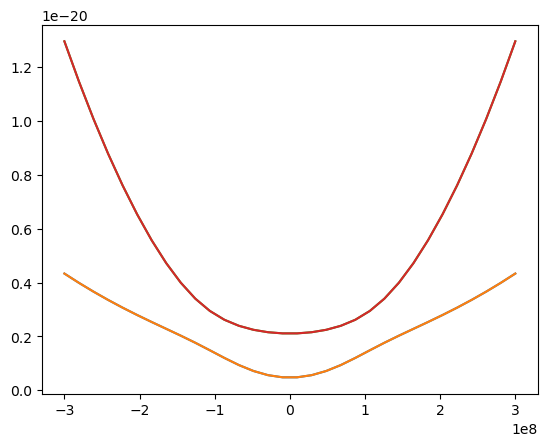

In [31]:
plt.plot(*H.spectrum([-3e8,3e8],[1,0],32))

In [13]:
solution = solver.solve(model)

In [14]:
print(solution[0]*nqcpfem.UNIT_CONVENTION['J to eV']*1000)

[14.33847182 14.33847182 20.5437642  20.5437642  21.75591174 21.75591174
 26.58344895 26.58344895 28.37641388 28.37641388 28.79624408]


In [15]:
from nqcpfem.plotting import plot_eigenvector
plot_eigenvector(solution[1][0],model)

Widget(value="<iframe src='http://localhost:37991/index.html?ui=P_0x7f5e30901090_3&reconnect=auto' style='widt…

Next, we add superconductivity 

In [42]:
H.BdG_extension()
H.independent_vars['Delta_SC'] = delta* sympy.Array(sympy.eye(4)) # Identity-like Delta
H.post_processed_array().subs('\hbar','hbar')

H.add_potential(-mu)

In [47]:

H.parameter_dict[mu] = 19e-22
from matplotlib import pyplot as plt



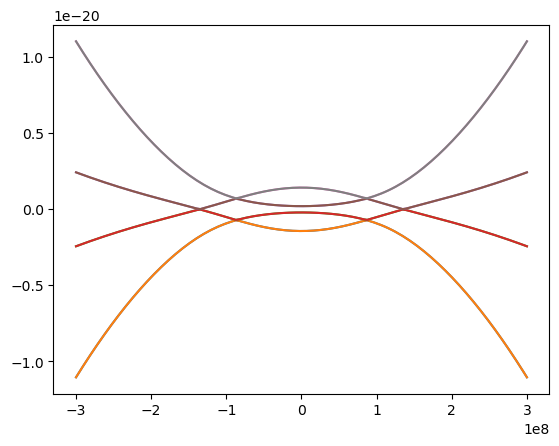

In [48]:

plt.plot(*H.spectrum((-3e8,3e8),[0,1],128))


In [49]:
try: 
    sc_solution = solver.solve(model)
except Exception as err:
    raise err

INFO:root:running build_ext
INFO:root:building 'libffcx_forms_8e5ab1db64a01fb39d279d3b64b5dded61840c7e' extension
INFO:root:/home/oliver/miniconda3/envs/Germanium_Spins_FE/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/Germanium_Spins_FE/include -fPIC -I/home/oliver/miniconda3/envs/Germanium_Spins_FE/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/Germanium_Spins_FE/include/python3.10 -c libffcx_forms_8e5ab1db64a01fb39d279d3b64b5dded61840c7e.c -o ./libffcx_forms_8e5ab1db64a01fb39d279d3b64b5dded61840c7e.o -O2 -g0
INFO

In [50]:
sc_solution[0]

array([ 3.97276451e-22,  3.97276451e-22, -3.97276451e-22, -3.97276451e-22,
        1.39147390e-21,  1.39147390e-21, -1.39147390e-21, -1.39147390e-21,
        1.58568134e-21, -1.58568134e-21])

In [52]:
plot_eigenvector(sc_solution[1][2],model)

Widget(value="<iframe src='http://localhost:37991/index.html?ui=P_0x7f5e01792440_5&reconnect=auto' style='widt…

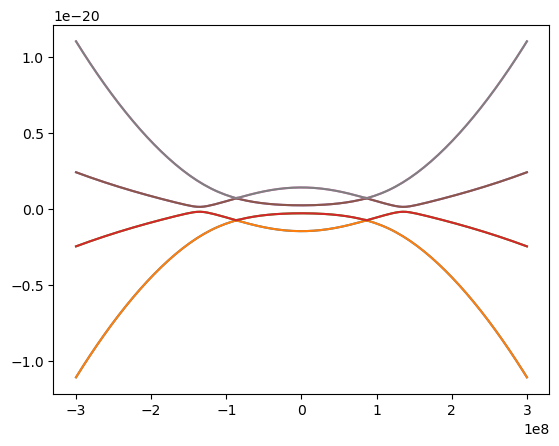

In [57]:

H.parameter_dict[delta] = 1/( nqcpfem.UNIT_CONVENTION['J to eV']*1000)
plt.plot(*H.spectrum((-3e8,3e8),[0,1],128))

In [61]:

sc_gap_sol = solver.solve(model)
sc_gap_sol[0]

array([ 4.28366990e-22, -4.28366990e-22,  4.28366990e-22, -4.28366990e-22,
       -1.40066745e-21,  1.40066745e-21, -1.40066745e-21,  1.40066745e-21,
        1.59375501e-21, -1.59375501e-21])

INFO:root:client 4859db51b3e04af186706ef59d8c2a69 disconnected
INFO:aiohttp.access:127.0.0.1 [17/Aug/2023:20:55:31 +0000] "GET /ws HTTP/1.1" 101 0 "-" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.81.1 Chrome/108.0.5359.215 Electron/22.3.18 Safari/537.36"
INFO:root:client 3686b9ad3f9d42a8bf651fd44d55be86 disconnected
INFO:aiohttp.access:127.0.0.1 [17/Aug/2023:20:21:25 +0000] "GET /ws HTTP/1.1" 101 0 "-" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.81.1 Chrome/108.0.5359.215 Electron/22.3.18 Safari/537.36"
INFO:root:client a51abf3c19c040ebaadf668f3d776819 disconnected
INFO:root:No more connections, scheduling shutdown
INFO:aiohttp.access:127.0.0.1 [17/Aug/2023:20:58:12 +0000] "GET /ws HTTP/1.1" 101 0 "-" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.81.1 Chrome/108.0.5359.215 Electron/22.3.18 Safari/537.36"
INFO:root:client 16d9388ea3ba419d86bbf62e70667f73 co

In [60]:
plot_eigenvector(sc_gap_sol[1][],model)

Widget(value="<iframe src='http://localhost:37991/index.html?ui=P_0x7f5df62a7f40_6&reconnect=auto' style='widt…